Refs:
- https://www.tdt.com/docs/sdk/offline-data-analysis/offline-data-python/
- https://www.tdt.com/docs/sdk/offline-data-analysis/tdt-data-storage/

In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import tdt

In [26]:
data_path = "/media/luiz/Seagate Basic/storage/catalystneuro/nelson_lab/Raw_TDT_photometry_withVideos/"
data = tdt.read_block(block_path=data_path)
data.info

read from t=0s to t=11265.36s


tankpath:	'/media/luiz/Seagate Basic/storage/catalystneuro/nelson_lab'
blockname:	'Raw_TDT_photometry_withVideos'
start_date:	datetime.datetime(2023, 9, 12, 19, 30, 30, 999999)
utc_start_time:	'19:30:30'
stop_date:	datetime.datetime(2023, 9, 12, 22, 38, 16, 357144)
utc_stop_time:	'22:38:16'
duration:	datetime.timedelta(seconds=11265, microseconds=357145)
stream_channel:	0
snip_channel:	0

In [27]:
b = data.info.start_date.replace(tzinfo=timezone.utc)
b

datetime.datetime(2023, 9, 12, 19, 30, 30, 999999, tzinfo=datetime.timezone.utc)

# Streams

In [28]:
data['streams'].keys()

dict_keys(['_405A', '_465A', 'Fi1r'])

In [29]:
data['streams']['_405A']

name:	'_405A'
code:	1094004788
size:	138
type:	33025
type_str:	'streams'
ucf:	False
fs:	1017.2526245117188
dform:	0
start_time:	0.0
data:	array([ 0.36175394,  0.36218846,  0.3625871 , ..., 48.76594   ,
       48.765903  , 48.76586   ], dtype=float32)
channel:	[1]

In [30]:
data['streams']['_405A'].data.size / (data['streams']['_405A'].fs * 3600)

3.1292303416820597

In [31]:
data['streams']['_465A']

name:	'_465A'
code:	1094006324
size:	138
type:	33025
type_str:	'streams'
ucf:	False
fs:	1017.2526245117188
dform:	0
start_time:	0.0
data:	array([  0.23966293,   0.23960435,   0.2397883 , ..., 109.91514   ,
       109.92649   , 109.93785   ], dtype=float32)
channel:	[1]

In [33]:
# This is also important to convert
data['streams']['Fi1r']

name:	'Fi1r'
code:	1915840838
size:	522
type:	33025
type_str:	'streams'
ucf:	False
fs:	6103.515625
dform:	0
start_time:	0.0
data:	array([[0.0000000e+00, 7.1926373e-01, 6.6676062e-01, ..., 9.6822631e-01,
        9.3698347e-01, 8.9703602e-01],
       [0.0000000e+00, 6.8691301e-01, 7.7112681e-01, ..., 8.9518225e-01,
        9.5470297e-01, 9.9082607e-01],
       [1.4343481e-02, 1.0986496e-02, 9.1554131e-04, ..., 7.6050961e-01,
        7.7149612e-01, 8.1666285e-01]], dtype=float32)
channel:	[1, 2, 3]

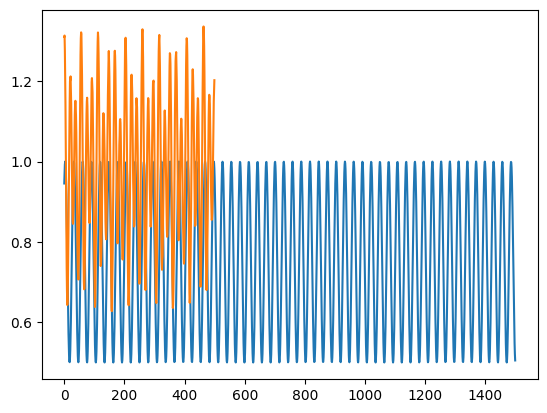

In [34]:
plt.figure()
plt.plot(data['streams']['Fi1r'].data[0][9000:10500])
# plt.plot(data['streams']['Fi1r'].data[1][10000:10500])
plt.plot(data['streams']['Fi1r'].data[2][10000:10500])

# Epocs

In [35]:
data.epocs

TTL1	[struct]
Cam1	[struct]
Cam2	[struct]

In [36]:
data.epocs.TTL1

name:	'TTL1'
onset:	array([2174.46776832])
offset:	array([inf])
type:	'onset'
type_str:	'epocs'
data:	array([0.])
dform:	4
size:	10

In [37]:
data.epocs.Cam1

name:	'Cam1'
onset:	array([2.06929920e-01, 2.51494400e-01, 3.06380800e-01, ...,
       1.12651557e+04, 1.12652137e+04, 1.12652571e+04])
offset:	array([2.51494400e-01, 3.06380800e-01, 3.57662720e-01, ...,
       1.12652137e+04, 1.12652571e+04,            inf])
type:	'onset'
type_str:	'epocs'
data:	array([0., 0., 0., ..., 0., 0., 0.])
dform:	4
size:	10

In [50]:
data.epocs["Cam2"]

name:	'Cam2'
onset:	array([2.07421440e-01, 2.51822080e-01, 3.07691520e-01, ...,
       1.12651515e+04, 1.12652101e+04, 1.12652521e+04])
offset:	array([2.51822080e-01, 3.07691520e-01, 3.58481920e-01, ...,
       1.12652101e+04, 1.12652521e+04,            inf])
type:	'onset'
type_str:	'epocs'
data:	array([0., 0., 0., ..., 0., 0., 0.])
dform:	4
size:	10

In [51]:
data.epocs.Cam2.onset[0:25]

array([0.20742144, 0.25182208, 0.30769152, 0.35848192, 0.40108032,
       0.45121536, 0.50282496, 0.55246848, 0.60309504, 0.65601536,
       0.70647808, 0.75464704, 0.80461824, 0.85573632, 0.90554368,
       0.95404032, 1.00483072, 1.056768  , 1.10362624, 1.15359744,
       1.20127488, 1.25288448, 1.30236416, 1.3541376 , 1.40181504])

In [52]:
len(data.epocs.Cam2.onset)

225303

# Scalars

In [ ]:
data.scalars['Fi1i']

In [ ]:
2100 / 60

# Data Interface for conversion

In [10]:
from nelson_lab_to_nwb.interfaces import TdtFiberPhotometryInterface
from pynwb import NWBHDF5IO, NWBFile

In [6]:
folder_path = "/media/luiz/Seagate Basic/storage/catalystneuro/nelson_lab/Raw_TDT_photometry_withVideos"
metadata_path = "/mnt/shared_storage/Github/nelson-lab-to-nwb/src/nelson_lab_to_nwb/interfaces/metadata_example.yaml"
data_interface = TdtFiberPhotometryInterface(
    folder_path=folder_path,
    metadata_path=metadata_path
)

read from t=0s to t=11265.36s


In [7]:
metadata = data_interface.get_metadata()
dict(metadata)

{'NWBFile': DeepDict: {'session_description': 'Day 1 of levodopa.', 'identifier': '9d5d1770-a008-4aa5-aa9d-e37581b12608', 'session_start_time': datetime.datetime(2023, 9, 12, 19, 30, 30, 999999, tzinfo=datetime.timezone.utc), 'institution': 'University of California San Francisco', 'lab': 'Nelson Lab', 'experimenter': ['Paz, Rodrigo', 'Last, First Middle'], 'pharmacology': 'Levodopa concentration: 5mg/kg.'},
 'Subject': {'subject_id': 'rp230717g',
  'genotype': 'A2A-Cre',
  'description': '6-OHDA left MFB; Flex-GCaMP6s DLS; 400um Fiber',
  'species': 'Mus musculus',
  'date_of_birth': datetime.datetime(2023, 3, 17, 0, 0),
  'sex': 'F'},
 'Ophys': {'FiberPhotometry': {'Fibers': [{'location': 'Location of this fiber',
     'coordinates': [0.0, 0.0, 0.0],
     'notes': 'extra notes',
     'fiber_model_number': 'The model number of the fiber',
     'dichroic_model_number': 'The model number of the dichroic mirror'}],
   'ExcitationSources': [{'source_type': 'laser', 'peak_wavelength': 465.

In [8]:
data_interface.run_conversion(nwbfile_path="test_tdt.nwb")

In [11]:
io = NWBHDF5IO("test_tdt.nwb", 'r', load_namespaces=True)
nwbfile = io.read()
nwbfile

root pynwb.file.NWBFile at 0x140673517633712
Fields:
  acquisition: {
    Fi1r <class 'abc.FiberPhotometryResponseSeries'>,
    _405A <class 'abc.FiberPhotometryResponseSeries'>,
    _465A <class 'abc.FiberPhotometryResponseSeries'>
  }
  experimenter: ['Paz, Rodrigo' 'Last, First Middle']
  file_create_date: [datetime.datetime(2024, 3, 25, 13, 38, 33, 409865, tzinfo=tzoffset(None, 3600))]
  identifier: f77c7df2-75e4-476a-85c5-69d030032892
  institution: University of California San Francisco
  lab: Nelson Lab
  lab_meta_data: {
    fiber_photometry <class 'abc.FiberPhotometry'>
  }
  pharmacology: Levodopa concentration: 5mg/kg.
  session_description: Day 1 of levodopa.
  session_start_time: 2023-09-12 19:30:30.999999+00:00
  subject: subject pynwb.file.Subject at 0x140673517041184
Fields:
  age__reference: birth
  date_of_birth: 2023-03-17 00:00:00+01:00
  description: 6-OHDA left MFB; Flex-GCaMP6s DLS; 400um Fiber
  genotype: A2A-Cre
  sex: F
  species: Mus musculus
  subject_id: rp230717g

  timestamps_reference_time: 2023-09-12 19:30:30.999999+00:00

# Fiber photometry nwb

In [ ]:
import datetime
import numpy as np

from pynwb import NWBHDF5IO, NWBFile
from pynwb.core import DynamicTableRegion
from pynwb.ophys import RoiResponseSeries
from ndx_photometry import (
    FibersTable,
    PhotodetectorsTable,
    ExcitationSourcesTable,
    FluorophoresTable,
    FiberPhotometryResponseSeries,
    FiberPhotometry
)

In [ ]:
nwbfile = NWBFile(
    session_description="session_description",
    identifier="identifier",
    session_start_time=datetime.datetime.now(datetime.timezone.utc),
)

# Create a Fibers table, and add one (or many) fiber
fibers_table = FibersTable(description="fibers table")
fibers_table.add_row(    
    location="my location",
    notes="notes"
)

# Create an Excitation Sources table, and a one (or many) excitation source
excitationsources_table = ExcitationSourcesTable(description="excitation sources table")
excitationsources_table.add_row(
    peak_wavelength=700.0,
    source_type="laser",
)
excitationsources_table.add_row(
    peak_wavelength=800.0,
    source_type="laser",
)

# Create a Photodetectors table, and add one (or many) photodetector
photodetectors_table = PhotodetectorsTable(description="photodetectors table")
photodetectors_table.add_row(
    peak_wavelength=500.0, 
    type="PMT", 
    gain=100.0
)

# Create a Fluorophores table, and add one (or many) fluorophore
fluorophores_table = FluorophoresTable(description="fluorophores")
fluorophores_table.add_row(
    label="dlight",
    location="VTA",
    coordinates=(3.0,2.0,1.0)
)

# Here we add the metadata tables to the metadata section
nwbfile.add_lab_meta_data(
    FiberPhotometry(
        fibers=fibers_table,
        excitation_sources=excitationsources_table,
        photodetectors=photodetectors_table,
        fluorophores=fluorophores_table
    )
)

# Create a raw FiberPhotometryResponseSeries, this is your main acquisition
# We should create DynamicTableRegion referencing the correct rows for each table
fiber_ref = fibers_table.create_fiber_region(region=[0], description='source fiber')
excitation_ref = excitationsources_table.create_excitation_source_region(region=[0], description='excitation sources')
photodetector_ref = photodetectors_table.create_photodetector_region(region=[0], description='photodetector')
fluorophore_ref = fluorophores_table.create_fluorophore_region(region=[0], description='fluorophore')
fp_response_series = FiberPhotometryResponseSeries(
    name="MyFPRecording",
    data=np.random.randn(100, 1),
    unit='F',
    rate=30.0,
    fibers=fiber_ref,
    excitation_sources=excitation_ref,
    photodetectors=photodetector_ref,
    fluorophores=fluorophore_ref,
)

nwbfile.add_acquisition(fp_response_series)

# write nwb file
filename = 'test.nwb'
with NWBHDF5IO(filename, 'w') as io:
    io.write(nwbfile)

# read nwb file and check its contents
with NWBHDF5IO(filename, 'r', load_namespaces=True) as io:
    nwbfile = io.read()
    # Access and print information about the acquisition
    print(nwbfile.acquisition["MyFPRecording"])
    # Access and print all of the metadata
    print(nwbfile.lab_meta_data)

In [ ]:
io = NWBHDF5IO(filename, 'r', load_namespaces=True)
nwbfile = io.read()

In [ ]:
nwbfile.acquisition["MyFPRecording"]

# Behavior

In [53]:
import pandas as pd

# Path to your Excel file
file_path = '/media/luiz/Seagate Basic/storage/catalystneuro/nelson_lab/Raw_TDT_photometry_withVideos/Behavior_rp230717g-230912.xlsx'

# Function to find the header row index
def find_header_row(file_path):
    # Attempt to open the file as an Excel workbook
    with pd.ExcelFile(file_path, engine='openpyxl') as xls:
        # Loop through each row in the first sheet
        for sheet_name in xls.sheet_names:
            sheet = xls.parse(sheet_name=sheet_name, header=None)
            for row_idx, row in sheet.iterrows():
                # Check for a specific pattern or keywords in the row
                if "Trial time" in row.values and "Recording time" in row.values:
                    return row_idx
    # Return None if no header is found
    return None

# Find the header row index
header_row = find_header_row(file_path)
if header_row is not None:
    df = pd.read_excel(file_path, header=header_row, engine='openpyxl')
    df = df.drop(index=0)
else:
    print("Header row not found.")


In [54]:
df

,Trial time,Recording time,X center,Y center,Area,Areachange,Elongation,Distance moved,Velocity,Rotation,Rotation 2,Result 1
1,1.05,0,3.08469,-17.8852,11.3959,0.415566,0.402141,-,-,0,0,1.0
2,1.1,0.05,3.04333,-17.8808,11.5073,0.616923,0.411611,0.041601,0.832012,0,0,1.0
3,1.15,0.1,2.96621,-17.9166,11.7944,1.22956,0.378914,0.085053,1.70106,0,0,1.0
4,1.2,0.15,2.90918,-17.9312,11.8543,0.668333,0.374813,0.058857,1.17714,0,0,1.0
5,1.25,0.2,2.85958,-17.9727,11.5416,0.784006,0.368684,0.064683,1.29366,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
225291,11265.55,11264.5,1.98431,-19.6866,10.0721,0,0.20828,0.000273,0.005464,0,0,1.0
225292,11265.6,11264.55,1.98043,-19.6896,10.0507,0.149947,0.202267,0.004884,0.097676,0,0,1.0
225293,11265.65,11264.6,1.97981,-19.6903,10.055,0.004284,0.203286,0.000958,0.019154,0,0,1.0
225294,11265.7,11264.65,1.97893,-19.6911,10.055,0,0.203286,0.001172,0.023446,0,0,1.0


In [59]:
def fill_missing_values(arr, step=0.05, missing_value=None):
    filled_arr = []
    n = len(arr)
    i = 0
    while i < n-1:
        filled_arr.append(arr[i])
        # Calculate the expected next value
        next_value = arr[i] + step
        # Check if the actual next value in the array matches the expected next value
        if abs(arr[i+1] - next_value) > 1e-5:  # Using a tolerance to avoid floating-point arithmetic issues
            # If not, a value is missing. Insert the missing value.
            print("here")
            while abs(arr[i+1] - next_value) > 1e-5:
                filled_arr.append(missing_value)
                next_value += step
        i += 1
    filled_arr.append(arr[-1])  # Add the last item
    return filled_arr

In [60]:
initial_array = df["Trial time"].values
filled_array = fill_missing_values(initial_array)

print(len(initial_array))
print(len(filled_array))

225295
225295


In [23]:
df = pd.read_excel(io='/media/luiz/Seagate Basic/storage/catalystneuro/nelson_lab/Raw_TDT_photometry_withVideos/Processed_behavior_LID_v2.xlsx')

In [24]:
df

,Time (minutes relative to injection),Velocity,Rotations1,Rotations2,Rot resultant,Transient #,Transient Amp,Transient peak,Avg fluoresence,AIMS
0,-29,1.575832,0,2,-2,16,0.032179,1.040026,1.021861,0.0
1,-28,0.199033,0,0,0,11,0.042862,1.023641,0.999980,0.0
2,-27,0.161069,0,0,0,13,0.036136,1.020743,0.996937,0.0
3,-26,0.177080,0,0,0,13,0.040730,1.022916,0.993708,0.0
4,-25,0.427195,0,0,0,13,0.050105,1.063501,1.030133,0.0
...,...,...,...,...,...,...,...,...,...,...
145,116,0.063070,0,0,0,14,0.060807,1.025049,0.977917,NaN
146,117,0.055896,0,0,0,13,0.061171,1.031371,0.989714,NaN
147,118,0.030636,0,0,0,13,0.051428,1.011473,0.979597,NaN
148,119,0.030314,0,0,0,14,0.049652,1.019436,0.981787,NaN
